Funcation = add_noise --->  given original image $x_{0}$ and timestep and noise we can get $x_{t}$

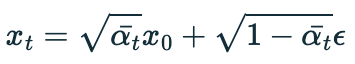

### funcation = step -->

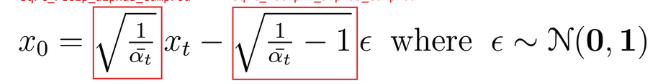

`pred_original_sample = (sample - beta_bar_t ** (0.5) * model_output) / alpha_bar_t**(0.5)`

pred_original_sample = **$x_{0}$** , here **$x_{t}$** is basically sample and model_output is predicted noise that is **$\epsilon$**

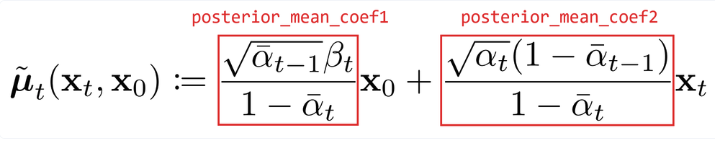



```
pred_original_sample_coeff = (alpha_bar_t_prev ** (.5) * current_beta_t) / beta_bar_t           
current_sample_coeff = current_alpha_t ** (0.5) * beta_bar_t_prev / beta_bar_t
pred_prev_sample = pred_original_sample_coeff*pred_original_sample + current_sample_coeff * sample
```

**For the variance we can either use $\beta_{t}$ or we can use $\bar{\beta}$. and $\beta_{t}$ is simple our variance schedule** we use `get_variance` funcation to implement $\bar{\beta}$



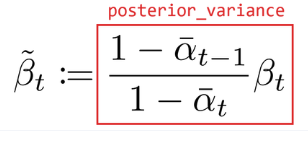



```
alpha_bar_t = self.alpha_bar[t]
alpha_bar_t_prev = self.alpha_bar[prev_t] if prev_t >= 0 else self.one
current_beta_t = 1 - alpha_bar_t / alpha_bar_t_prev
variance = (1 - alpha_bar_t_prev) / (1 - alpha_bar_t) * current_beta_t
```



In [ ]:
import torch
import numpy as np
class DDPM_scheduler:
  def __init__(self, beta_start = .0001 , beta_end = .02 , beta_schedule = 'linear' , num_train_step = 1000 , clip_sample_range= 1.0 ,num_inference_steps = 50):
    if beta_schedule == 'linear':
      self.beta = torch.linspace(beta_start , beta_end , num_train_step , dtype = torch.float32)


    self.alpha = 1.0 - self.beta
    self.alpha_bar = torch.cumprod(self.alpha , dim=0)

    self.one = torch.tensor(1.0)
    self.init_noise_sigma = 1.0
    self.clip_sample_range = clip_sample_range

    self.num_inference_steps=num_inference_steps
    self.num_train_step = num_train_step

    self.timesteps = torch.from_numpy(np.arange(0 , num_train_step)[::-1].copy())         ### 9, 8, 7, 6, 5, 4, 3, 2, 1, 0


  def _get_variance(self , t , predicted_variance = None):
    prev_t = self.previous_timestep(t)
    alpha_prod_t = self.alpha_bar[t]
    alpha_prod_t_prev = self.alpha_bar[prev_t] if prev_t >= 0 else self.one
    current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

    variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

    # we always take the log of variance , so clamp it ot ensure it's not 0
    variance = torch.clamp(variance , min = 1e-20)

    return variance

  def step(self , model_output , timestep , sample , generator = None):

    t = timestep
    prev_t = self.previous_timestep(t)

    predicted_variance = None

    alpha_bar_t = self.alpha_bar[t]
    alpha_bar_t_prev = self.alpha_bar[prev_t] if prev_t >= 0 else self.one
    beta_bar_t = 1 - alpha_bar_t
    beta_bar_t_prev = 1 - alpha_bar_t_prev
    current_alpha_t = alpha_bar_t / alpha_bar_t_prev
    current_beta_t = beta_bar_t / beta_bar_t_prev

    pred_original_sample = (sample - beta_bar_t ** (0.5) * model_output) / alpha_bar_t**(0.5)      # predicting x_0 using above formulae
    pred_original_sample = pred_original_sample.clamp(-self.clip_sample_range , self.clip_sample_range)

    pred_original_sample_coeff = (alpha_bar_t_prev ** (.5) * current_beta_t) / beta_bar_t           #getting the coefficient for predicted mean
    current_sample_coeff = current_alpha_t ** (0.5) * beta_bar_t_prev / beta_bar_t

    pred_prev_sample = pred_original_sample_coeff*pred_original_sample + current_sample_coeff * sample

    variance = 0

    if t> 0:
      device = model_output.device
      variance_noise = torch.randn(model_output.shape , device = device , dtype = model_output.dtype)

    pred_prev_sample = pred_prev_sample + variance

    return (pred_prev_sample , pred_original_sample)

  def add_noise(self , original_sample , noise , timestep):
    device = original_sample.device                               # load all tensor onto same device
    alpha_bar = self.alpha_bar.to(device)
    timestep = timestep.to(device)

    sqrt_alpha_bar = alpha_bar[timestep] ** .5
    sqrt_alpha_bar = sqrt_alpha_bar.flatten()                   # flatten convert multidimension into 1-d tensor

    while len(sqrt_alpha_bar.shape) < len(original_sample.shape):     # add dim in las till shape of alpha_bar equal to given image

      sqrt_alpha_bar = sqrt_alpha_bar.unsqueeze(-1)

    sqrt_one_minus_alpha_bar = (1 - alpha_bar[timestep]) ** .5
    sqrt_one_minus_alpha_bar = sqrt_one_minus_alpha_bar.flatten()

    noisy_sample = sqrt_alpha_bar * original_sample + sqrt_one_minus_alpha_bar * noise
    return noisy_sample

  def previous_timestep(self , timestep):
    num_inference_steps = self.num_inference_steps if self.num_inference_steps else self.num_train_step
    prev_t = timestep - self.num_train_step // num_inference_steps
    return prev_t



In [ ]:
scheduler = DDPM_scheduler()

In [ ]:
image = torch.randn(1,3,128,128)

In [ ]:
image_shape = image.shape

In [ ]:
device = "cpu"

image = image.to(device)

In [ ]:
for t in range(50):
  model_output = image
  image = scheduler.step(model_output ,t , image)[0]

In [ ]:
scheduler.add_noise(image , image ,torch.tensor(1))

tensor([[[[ 0.1456,  0.3697,  0.3608,  ..., -0.8539, -0.6036,  0.3600],
          [ 0.5888,  0.2637,  0.9814,  ..., -0.5654, -0.9703,  0.7873],
          [ 0.7466, -1.7886, -1.0901,  ...,  0.8238, -2.1813,  0.9312],
          ...,
          [ 0.4313, -1.7864,  0.7444,  ...,  1.6175,  1.1610,  1.2771],
          [ 0.1944, -0.4048,  0.7600,  ...,  0.5438,  0.3401, -0.7713],
          [-1.1575, -1.4178,  1.0554,  ..., -0.7163, -0.2965, -0.6471]],

         [[-1.7592, -1.1570,  0.3073,  ..., -0.0225,  0.5237,  1.0670],
          [ 0.2883, -0.9110, -0.1863,  ..., -0.3768, -0.4101, -0.9916],
          [-1.6846, -0.1064, -0.0927,  ..., -1.1254,  1.3153,  1.7749],
          ...,
          [ 0.3876,  2.9782, -0.6869,  ...,  0.9897, -0.1426,  1.3163],
          [-0.2843, -1.1879, -1.2048,  ...,  1.3290, -0.1597,  0.9816],
          [ 0.9876, -3.0373, -0.3469,  ...,  0.5366,  0.4130,  1.1846]],

         [[-0.1690, -2.1470,  0.2835,  ..., -1.8751, -1.7254, -0.9203],
          [-2.1117,  0.0126, -